In [1]:
import sys, os, json
from pathlib import Path
PROJECT_ROOT = Path(os.getcwd()).resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

DATA_DIR = PROJECT_ROOT / "data" / "processed"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# !pip install --upgrade typing_extensions
# !pip install openai
from openai import OpenAI
from dotenv import load_dotenv
from pathlib import Path
from src.data.raw_data_inspection import inspect_raw_data
from src.data.create_dataset import split_and_save
from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import format_case_row, FewShotExample, build_fewshot_block, call_gpt_batch, stratified_sample_U
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors
from src.models.baseline import train_logreg, evaluate
from src.models.conformal_prediction import calibrate_threshold, cp_partition, summarize_counts
from src.models.expert_integration import format_case_row, FewShotExample, build_fewshot_block, call_gpt_batch, stratified_sample_U, gpt_multiple_runs, evaluate_gpt_runs, bootstrap_sensitivity_ci, new_fn_after_deferral
from src.evaluation.metrics import confusion_from_preds, sensitivity_specificity, wilson_ci, new_errors
from src.visualization.eda import plot_label_distribution, plot_continuous_hists_by_label, plot_violin_by_label, plot_categorical_counts_by_label, plot_corr_heatmap
from src.data.preprocess import build_preprocessor, split_X_y
from src.visualization.model_vis import plot_logreg_coeffs, plot_calibration, plot_confusion_matrix, plot_prob_distribution
from src.visualization.cp_vis import plot_cp_results, plot_cp_gpt_measured
from src.evaluation.bootstrap_baseline import bootstrap_baseline


## Introduction

I examine how does sole accuracy causes issue in medical AI and how far uncertainty-aware methods can push safety. I train a logistic regression baseline on electronic health records for glaucoma diagnosis; the model scores highly (ACC ≈ 0.93, AUROC ≈ 0.98) yet still misses six diseased patients. I apply conformal prediction (CP) to separate confident from uncertain cases, enabling deferral of ambiguous predictions. I set the upper bound with an oracle expert that eliminates nearly all false negatives, and the lower bound with a GPT proxy that, while imperfect, still reduces errors compared with the baseline. This exploration highlights both the promise and the limits of uncertainty-aware methods, illustrating that accuracy alone is insufficient while also noting that safer models often come at the cost of reduced coverage.

## Explorative Data Analysis

### Dataset metrics

In [2]:
RAW_CSV = PROJECT_ROOT / "data" / "raw" / "ds_whole.csv"
df = inspect_raw_data(RAW_CSV)

Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RL                499 non-null    object 
 1   glaucoma          499 non-null    int64  
 2   age               499 non-null    int64  
 3   ocular_pressure   499 non-null    int64  
 4   MD                499 non-null    float64
 5   PSD               499 non-null    float64
 6   GHT               499 non-null    int64  
 7   cornea_thickness  499 non-null    int64  
 8   RNFL4.mean        499 non-null    float64
dtypes: float64(3), int64(5), object(1)
memory usage: 35.2+ KB
None 

Missing Values Info
RL                  0
glaucoma            0
age                 0
ocular_pressure     0
MD                  0
PSD                 0
GHT                 0
cornea_thickness    0
RNFL4.mean          0
dtype: int64 

Basic Summary
         RL    glaucoma         age  ocular_pressure

1. The dataset has 499 samples, and it is fairly balanced, with about 60% positive cases and 40% negative cases. 

2. It has 9 features: age, ocular pressure, MD, PSD, GHT, cornea thickness, RNFL4.mean, RL, glaucoma. Please check this website for variable definition: https://www.kaggle.com/code/muhammadfaizan65/human-glaucoma-eda-gbc/input. 

3. The dataset has no missing values.

### Visualizations

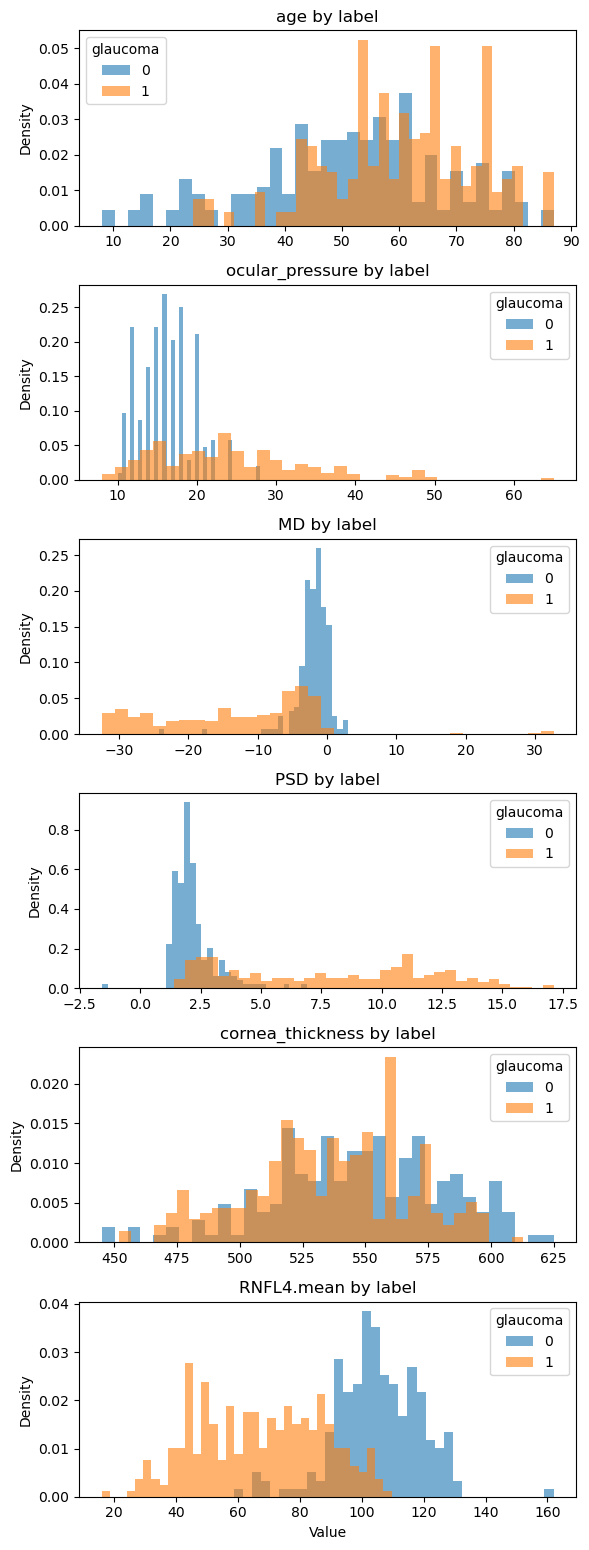

In [3]:
plot_continuous_hists_by_label(df, bins=35)

MD、PSD、RNFL are strongly discriminative features in this dataset. However, there still exists overlaps, where False Negative cases might happen.

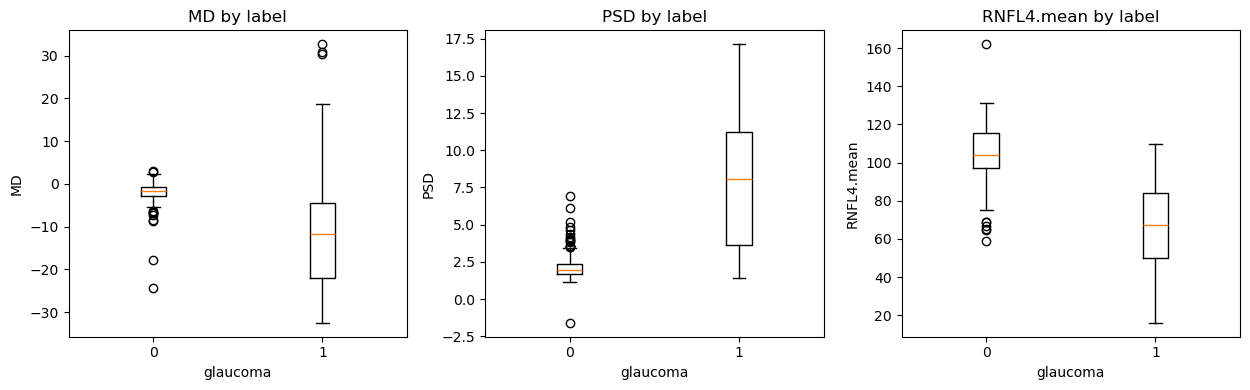

In [4]:
plot_violin_by_label(df, cols=("MD","PSD","RNFL4.mean"))

Taking a closer look on these variables, MD variable separates groups clearly, positive cases' PSD has higher variance with some overlapping regions, RNFL4.mean has significant difference with some overlapping.

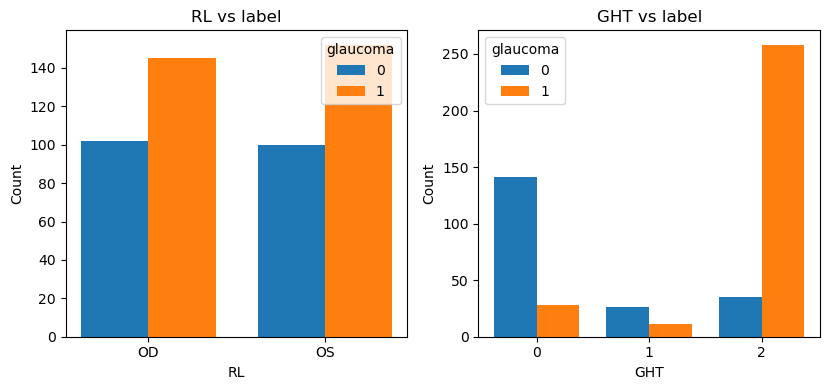

In [5]:
plot_categorical_counts_by_label(df, cols=["RL","GHT"])

1. RL has no clear difference between positive and negative cases.

2. Positive cases cluster around high value of GHT, negative cases at ower values.

3. Taken these information together, we can use few shot training to train an LLM to mimic medical expert on learning these three variables.

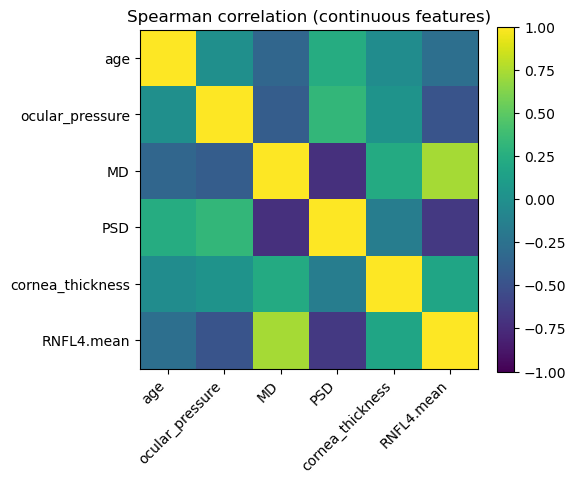

In [6]:
plot_corr_heatmap(df)

1. MD strongly positively correlated with RNFL4.mean.

2. PSD negatively correlated with MD.

3. Age, cornea thickness, and ocular pressure show weaker associations.

Some redundancy exists, such as MD and RNFL, which worsen model's capability to classify cases.

## Baseline Model

This section establishes a logistic regression baseline for glaucoma prediction, reports its overall accuracy and error counts, and highlights the presence of false negatives despite strong global metrics.

### Model Performance

Here the dataset is split into training, calibration, and test sets, and a logistic regression baseline is trained and evaluated on the test set, producing key performance metrics including false negatives. Here the test predictions are then bootstrapped 500 times to compute stable estimates and confidence intervals for FN, ACC, AUROC, Recall, Precision, and F1, giving a more reliable baseline assessment.

In [7]:
split_and_save(test_size=0.2, calib_size=0.2, random_state=42)
train = pd.read_pickle(DATA_DIR / "train.pkl")
calib = pd.read_pickle(DATA_DIR / "calib.pkl")
test  = pd.read_pickle(DATA_DIR / "test.pkl")

pipe = train_logreg(train)

m_test, proba_test, yhat_test = evaluate(pipe, test, threshold=0.5)
FN_baseline = m_test["FN"]
print("Baseline metrics:", m_test)

Baseline metrics: {'ACC': 0.93, 'AUROC': 0.9842910293509715, 'TP': 53, 'FP': 1, 'TN': 40, 'FN': 6, 'RECALL': 0.8983050847457474, 'PRECISION': 0.9814814814814633, 'F1': 0.9380530973451244}


In [8]:
X_test, y_test_true = split_X_y(test)
proba_pos = proba_test[:, 1] if getattr(proba_test, "ndim", 1) == 2 else proba_test

boot_df, boot_summary = bootstrap_baseline(y_true=y_test_true, proba_pos=proba_pos, n_boot=500, threshold=0.5, random_state=42)

display(boot_summary.loc[["FN","ACC","AUROC","RECALL","PRECISION","F1"]])

,mean,ci_low,ci_high
FN,6.094000,1.000000,11.000000
ACC,0.929300,0.874750,0.980000
AUROC,0.984130,0.964303,0.998083
RECALL,0.896404,0.814156,0.979592
PRECISION,0.981926,0.941176,1.000000
F1,0.936688,0.888889,0.980769


### Visualizations

Here, we use one case to illustrate the unreliability of the baseline model's sole dependence on the accuracy metric.

In [9]:
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

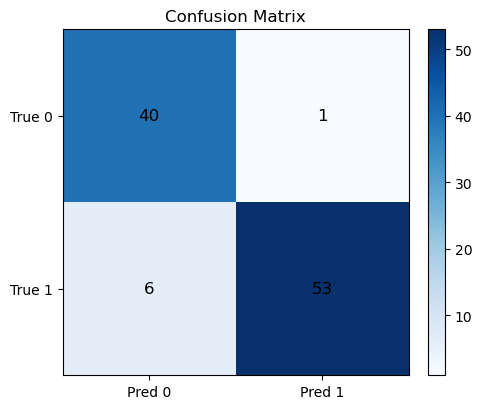

In [10]:
plot_confusion_matrix(test, yhat_test, save_path=FIG_DIR / "baseline_confusion.png")

1. The baseline logistic regression achieves strong overall performance (93% accuracy), but still produces 6 false negatives.

2. In a medical context, false negatives are the most dangerous type of error, since glaucoma patients would be told they are healthy.

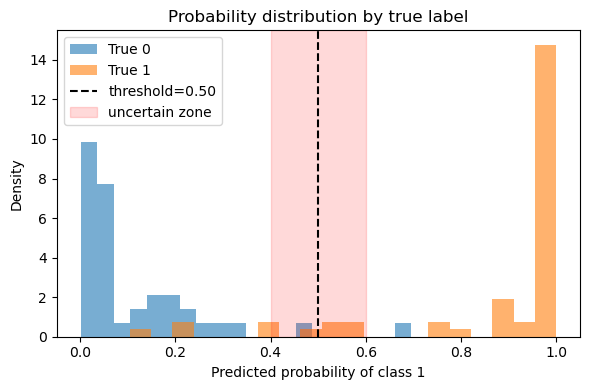

In [11]:
plot_prob_distribution(test, proba_test, save_path=FIG_DIR / "baseline_probdist.png")

1. Most predictions by the baseline model are correct, showing good separability.

2. However, in the zone highlighted by red, both classes overlap. These places are where the model is unsure, but still forced to make a hard decision ausing FN to happen.

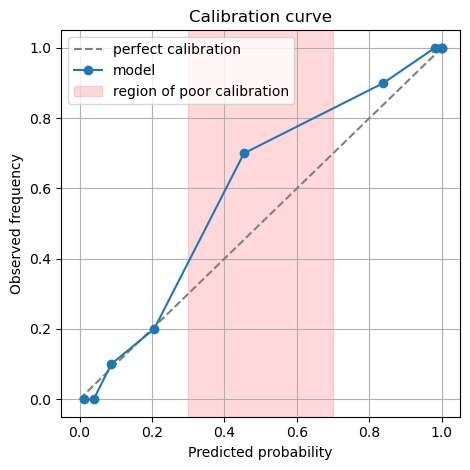

In [12]:
X_test, y_test_true = split_X_y(test)
plot_calibration(pipe, X_test, y_test_true, save_path=FIG_DIR / "baseline_calibration.png")

1. The model has fair calibration, but in the red highlighted region the curve deviates from the perfect calibration. This means predicted probabilities in this region don’t match the true likelihood of disease.

2. Clinicans cannot trust the model’s stated probabilities in this mid-range.

## Conformal Prediction Classification Model

This section introduces conformal prediction as an uncertainty-aware method, calibrates thresholds using a held-out set, and partitions test samples into confident and uncertain regions to evaluate its effect on false negatives.

### Model Performance

Here different significance levels alpha are tested to calibrate conformal prediction thresholds, partition test samples into confident and uncertain regions, and summarize the resulting error counts. A record of false negatives, false positives, and coverage at each alpha is collected in a DataFrame for later analysis and visualization against the baseline model.

In [13]:
alphas = [0.05, 0.10, 0.15, 0.20, 0.30]
records = []

for a in alphas:
    q = calibrate_threshold(pipe, calib, alpha=a)
    out = cp_partition(pipe, test, q)
    cnts = summarize_counts(out["y_true"], out["y_pred"], out["region"])
    cnts["alpha"] = a
    cnts["q"] = q
    cnts["FN_baseline"] = FN_baseline
    records.append(cnts)

df_cp = pd.DataFrame(records)
df_cp

,TP_confident,FN_confident,FP_confident,TN_confident,U_pos,U_neg,C_size,U_size,alpha,q,FN_baseline
0,53,6,1,40,0,0,100,0,0.05,0.685680,6
1,53,6,1,40,0,0,100,0,0.10,0.528078,6
2,49,3,1,39,7,1,92,8,0.15,0.393180,6
3,47,1,0,34,11,7,82,18,0.20,0.209705,6
4,45,1,0,26,13,15,72,28,0.30,0.109941,6


### Reasonable Approximation of Performance Upper Bound

This section estimates the best-case scenario by assuming an oracle expert perfectly resolves all uncertain cases, providing an upper bound on how much false negatives could be reduced with ideal expert intervention.

We introduce a formula to measure new false negatives after uncertain cases are deferred to an expert:
$$
FN_{\text{new}} = FN_{\text{confident}} + (1-s) \times U_{\text{pos}}, \quad
$$

Here s denotes sensitivity, the expert’s ability to correctly identify positive cases. The code applies this formula through the helper function new_errors. By setting s=1.0, we assume an oracle expert who never misses diseased patients in the uncertain region. In this case, all false negatives from the uncertain region vanish, and only the confident region contributes to the total. This represents the true upper bound of performance improvement under perfect expert review.

For illustration, the code also explores a synthetic imperfect expert with s=0.9. This example is not measured from data, but demonstrates how the formula accounts for realistic experts who occasionally miss positive cases. It serves as a conceptual middle ground between the perfect oracle and the GPT-based lower bound analyzed later.

In [14]:
def new_errors(FN_confident, U_pos, s: float):
    FN_new = FN_confident + (1 - s) * U_pos
    return FN_new

df_cp["FN_oracle"] = df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.U_pos, s=1.0), axis=1
)

s_gpt = 0.9
df_cp["FN_gpt"] = df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.U_pos, s=s_gpt), axis=1
)

Saved figure to: /Users/jasondai/Desktop/uncertainty-aware-medAI/reports/figures/cp_fn_coverage.png


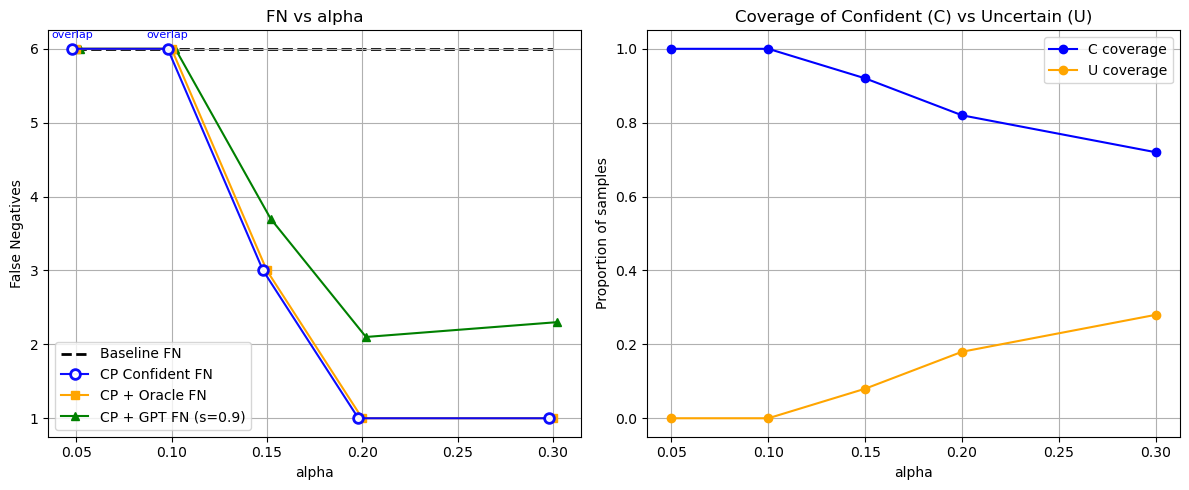

In [15]:
FIG_DIR = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

df_cp["FN_oracle"] = df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.U_pos, s=1.0), axis=1
)

s_gpt = 0.9
df_cp["FN_gpt"] = df_cp.apply(
    lambda r: new_errors(r.FN_confident, r.U_pos, s=s_gpt), axis=1
)

plot_cp_results(df_cp, total_size=len(test), s_gpt=s_gpt,
                save_path=FIG_DIR / "cp_fn_coverage.png")

Left Graph:

1. The black dashed line shows the baseline FN = 6: if we trust the model entirely, six glaucoma patients are missed.

2. Blue curve (“CP Confident FN”) shows that within the confident region, FN drop slightly as α increases, but the model is still making some misses.

3. Orange curve (“CP + Oracle FN”) shows the theoretical upper bound: if experts could always classify uncertain cases perfectly, FN would approach 1 at α=0.2 and above.

4. Green curve (“CP + GPT FN”) sits between baseline and oracle. With sensitivity ≈0.9 and specificity ≈0.85, GPT eliminates about half of the misses, but not all.

Right Graph:

1. Blue line: proportion of cases in the confident region decreases as α increases.

2. Orange line: uncertain cases grow with α, as higher α makes more samples flagged as uncertain. This trades off coverage for lower FN when experts step in. I think this reflect the cost of safety.

### Reasonable Approximation of Performance Lower Bound

This section establishes a conservative benchmark by using a GPT-based proxy to handle uncertain cases, providing a realistic lower bound on the potential reduction of false negatives when expert performance is imperfect.

Here we aim to give a pragmatic empirical estimation of the lower bound. I do not have the resources to bring in medical experts for glaucoma diagnosis, so instead I turn to a basic, outdated LLM with few-shot prompting. The few-shot examples are crafted to emphasize discriminative features in the EHR data, but such a model is certainly less capable than a trained ophthalmologist.

The code below applies the same formula as in the upper bound case, but substitutes the sensitivity actually measured from the LLM’s repeated runs on the uncertain region. This provides a realistic lower bound where expert review is imperfect and false negatives are reduced but not eliminated.

In [16]:
%load_ext autoreload
%autoreload 2

PROJECT_ROOT = Path(os.getcwd()).resolve().parent
sys.path.append(str(PROJECT_ROOT))


DATA_DIR = PROJECT_ROOT / "data" / "processed"
FIG_DIR  = PROJECT_ROOT / "reports" / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

In [17]:
out = cp_partition(pipe, test, q)
test_u = test[out["region"] == "U"].copy()
print("Test-U size:", len(test_u), "\nLabel counts:\n", test_u["glaucoma"].value_counts())

out_calib = cp_partition(pipe, calib, q)
calib_u = calib[out_calib["region"] == "U"].copy()
dev_u, _ = stratified_sample_U(calib_u, n_per_class=4, seed=42)

fewshots = []
for _, row in dev_u.iterrows():
    case_card = format_case_row(row)
    fewshots.append(FewShotExample(case_card=case_card, label=int(row["glaucoma"])))
fewshot_block = build_fewshot_block(fewshots)
print(f"Few-shot examples: {len(fewshots)}")

Test-U size: 28 
Label counts:
 glaucoma
0    15
1    13
Name: count, dtype: int64
Few-shot examples: 8


In [18]:
all_preds = gpt_multiple_runs(OpenAI(), "gpt-4o-mini", test_u, fewshot_block, n_runs=5, temperature=0.2)

s_list, y_true_eval, preds_eval = evaluate_gpt_runs(all_preds, test_u["glaucoma"].values)
s_mean = float(s_list.mean())
s_ci = bootstrap_sensitivity_ci(preds_eval, y_true_eval, n_boot=1000, alpha=0.05)

print(f"Sensitivity per run: {s_list}")
print(f"Mean s: {s_mean:.3f}   95% CI: ({s_ci[0]:.3f}, {s_ci[1]:.3f})")

df_cp["FN_oracle"]   = df_cp.apply(lambda r: new_fn_after_deferral(r.FN_confident, r.U_pos, s=1.0), axis=1)
df_cp["FN_gpt_meas"] = df_cp.apply(lambda r: new_fn_after_deferral(r.FN_confident, r.U_pos, s=s_mean), axis=1)

GPT runs:   0%|          | 0/5 [00:00<?, ?it/s]

Sensitivity per run: [0.76923077 0.76923077 0.76923077 0.76923077 0.84615385]
Mean s: 0.785   95% CI: (0.533, 1.000)


Saved figure to: /Users/jasondai/Desktop/uncertainty-aware-medAI/reports/figures/cp_fn_gpt_measured_bootstrap.png


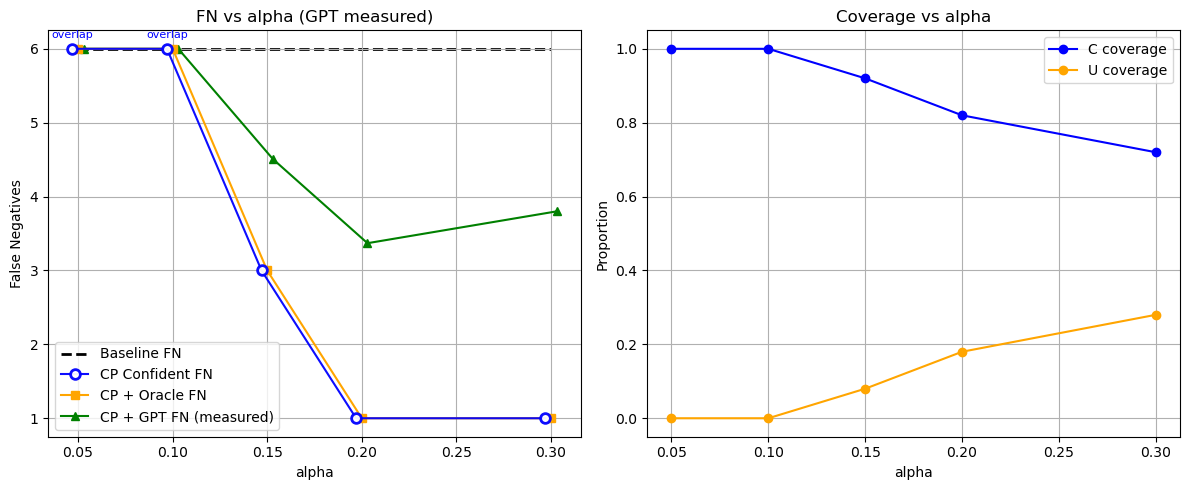

In [19]:
plot_cp_gpt_measured(df_cp, total_size=len(test), save_path=FIG_DIR / "cp_fn_gpt_measured_bootstrap.png")

Left Graph:

1. Green curve is now based on GPT’s empirically measured sensitivity (~0.78) on uncertain cases.

2. FN are reduced from baseline, but not as aggressively as in the first figure: they plateau around 3–4 misses instead of 1.

3. This highlights the practical lower bound: actual LLM “experts” won’t perfectly handle uncertain cases, but they still reduce FN significantly.

Right Graph:

1. Blue line: proportion of cases in the confident region decreases as α increases.

2. Orange line: uncertain cases grow with α, as higher α makes more samples flagged as uncertain. This trades off coverage for lower FN when experts step in. I think this reflect the cost of safety. 

## Conclusion

1. A logistic regression baseline achieved high overall performance but still produced six false negatives, showing that global accuracy can conceal serious case-level risks.

2. Conformal Prediction could be used to reduce false negative cases.

    a. With an oracle expert resolving all uncertain cases, false negatives were nearly eliminated.

    b. With a GPT proxy standing in for an imperfect expert, false negatives were reduced but not removed, giving a realistic performance floor.

3. CP improves safety by reducing false negatives but does so at the cost of coverage: more cases are deferred, which increases workload and resource demand. This study used a limited dataset and a proxy expert, so results illustrate trends rather than clinical deployment outcomes.